## Revel daily sales report: ingesting sales files provided by Ray

In [29]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime, timedelta
from itertools import compress
import matplotlib.ticker as mtick

In [2]:
os.getcwd()

'/home/mofongo/Documents/ghfc/salesAnalysis/github_finance'

In [3]:
os.chdir('/home/mofongo/Documents/ghfc/salesAnalysis/rawRevelExports/')

In [6]:
#this directory stores all sales files I wish to consolidate
#os.listdir('./revelSalesFiles')

In [4]:
excel_list = []
str_dir = './revelSalesFiles/'
for file in os.listdir('./revelSalesFiles/'):
    excel_list.append(pd.read_excel(str_dir+file))

In [6]:
history = pd.concat(excel_list, ignore_index = True)
history.shape

(296, 30)

In [7]:
history.head()

,Date,Taxable Sales,Non Taxable Sales,Service Fees,Discount,Sales Taxes,Net Sales,Unnamed: 7,Total Payments,Store Credit,...,Other,Other Credit,MasterCard,Debit,Maestro,Trade,Badges,House Account,Visa,Interac
0,03/27/2023,107.66,2040.25,0,271.14,9.55,1876.77,NaN,1886.32,0,...,0.00,0.0,288.42,0,0,0,0,0,1250.04,NaN
1,03/28/2023,168.33,2087.32,0,68.70,14.94,2186.95,NaN,2201.89,0,...,122.41,0.0,301.33,0,0,0,0,0,1394.75,NaN
2,03/29/2023,123.91,2062.63,0,149.08,10.99,2037.46,NaN,2048.45,0,...,0.00,0.0,281.16,0,0,0,0,0,1463.23,NaN
3,03/30/2023,238.64,1997.39,0,193.46,21.17,2042.57,NaN,2062.87,0,...,0.00,0.0,281.48,0,0,0,0,0,1512.60,NaN
4,03/31/2023,223.27,2702.30,0,176.94,19.82,2748.63,NaN,2768.45,0,...,0.00,0.0,530.99,0,0,0,0,0,1528.08,NaN


In [7]:
#fix the col headers
history.columns = [i.replace(' ','_') for i in history.columns]

In [14]:
history2 = history.loc[history['Date'] != 'Totals',:]

Remove the **Totals** row that appears at the end of each report import.

In [19]:
#sanity check on expected dates
history3 = history2.assign(Date = pd.to_datetime(history2['Date'],format = '%m/%d/%Y'))

Min = 12/26/2022; max = 9/24/2023

In [ ]:
history3['Date'].describe()

count                              259
mean     2023-05-07 18:48:38.918918912
min                2022-12-26 00:00:00
25%                2023-02-28 12:00:00
50%                2023-05-04 00:00:00
75%                2023-07-14 12:00:00
max                2023-09-24 00:00:00
Name: Date, dtype: object

In [ ]:
#check for duplicates
#columns to keep
cols_keep = ['Date', 'Discount', 'Net_Sales', 'Total_Payments']
#if TRUE, then no dupes
history3.drop_duplicates(cols_keep).shape == history3.shape

True

In [33]:
history3.shape

(259, 30)

In [34]:
pd.DataFrame?

Init signature:
pd.DataFrame(
    data=None,
    index: 'Axes | None' = None,
    columns: 'Axes | None' = None,
    dtype: 'Dtype | None' = None,
    copy: 'bool | None' = None,
) -> 'None'
Docstring:     
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order. If a dict contains Series
    which have an index defined, it is aligned by its index. This alignment also
    occurs if data is a Series or a DataFrame itself. Alignment is done on
    Series/DataFrame inputs.

    If data is a list of dicts, column order follows 

In [45]:
#detecting gaps in Date field: there are 15 days missing
history3.sort_values('Date', inplace=True)
sum(history3['Date'].diff()[1:] > timedelta(days=1))
history3['Date'].diff()[1:] > timedelta(days=1)

rel_df = history3.loc[1:,cols_keep]
rel_df = rel_df.assign(date_diff = history3['Date'].diff()[1:])
#history3['Date'].diff()[1:]])

In [46]:
rel_df.loc[rel_df['date_diff'] > timedelta(days = 1)]

,Date,Discount,Net_Sales,Total_Payments,date_diff
8,2023-06-26,41.82,2240.40,2261.49,8 days
40,2023-07-31,117.17,2256.45,2272.82,8 days


In [ ]:
#sort the DataFrame such that the value I want to keep for cases of dupes is first, so I can readily select for it using drop_duplicates later

#remove all records that have $0 gross sales
#history2 = history2.loc[history2['Gross_Sales']>0,:]
history2 = history.drop_duplicates(subset = 'Time_From' , keep ='first')
#remove all duplicate rows
history2 = history2.dropna(subset = ['Time_From'], axis = 0)
history2.shape

KeyError: Index(['Time_From'], dtype='object')

In [34]:
#keep only those columns whose rows' totals > 0
jk2 = history2.select_dtypes('float64').apply('sum')

In [35]:
#rebuild the dataframe
concat2 = pd.concat([
    history2.select_dtypes(exclude = 'float64'),
    history2.loc[:,list(jk2[jk2.apply(lambda x: x>0)].index)]],axis = 1)

In [36]:
#remove problematic rows: where 'Total' appears
concat2 = concat2.loc[concat2['Time_To']!='Total',:]

In [37]:
#make new datetime cols (note that these object INCLUDE a time component)
concat2 = concat2.assign(Time_From_dt = pd.to_datetime(concat2['Time_From'],format = '%m/%d/%Y %H:%M %p'),Time_To_dt = pd.to_datetime(concat2['Time_To'],format = '%m/%d/%Y %H:%M %p'))

In [38]:
#add a week and year to serve as groupby fields//Gregorian weeks according to ISO 8601
concat2 = concat2.assign(week_no = concat2['Time_From_dt'].dt.isocalendar().week, yr_no = concat2['Time_From_dt'].dt.isocalendar().year)

In [77]:
#another method to calc week from date, as isocalendar is funky
concat2.loc[concat2['yr_no']==2023,['Time_From','yr_no','week_no']]

,Time_From,yr_no,week_no
366,01/02/2023 03:00 AM,2023,1
367,01/03/2023 03:00 AM,2023,1
368,01/04/2023 03:00 AM,2023,1
369,01/05/2023 03:00 AM,2023,1
370,01/06/2023 03:00 AM,2023,1
371,01/07/2023 03:00 AM,2023,1
372,01/08/2023 03:00 AM,2023,1
373,01/09/2023 03:00 AM,2023,2
374,01/10/2023 03:00 AM,2023,2
375,01/11/2023 03:00 AM,2023,2


In [17]:
concat2.to_csv('./check_dates.csv',index=False)

In [18]:
os.getcwd()

'C:\\Users\\200669681\\OneDrive - NBCUniversal\\My Documents\\ghfc\\salesAnalysis'

In [39]:
#group by week
#calculate sum of values, grouped by week
test2 = concat2.groupby(['week_no','yr_no'])['Gross_Sales','Net_Sales', 'Total_Discounts'].sum()

C:\TEMP\ipykernel_6560\2592425039.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test2 = concat2.groupby(['week_no','yr_no'])['Gross_Sales','Net_Sales', 'Total_Discounts'].sum()


In [40]:
test3 = pd.concat([test2,concat2.groupby(['week_no','yr_no'])['Gross_Sales'].count()], axis = 1)

In [ ]:
#grouping instead in 7 day intervals
#print("\nGroup Dataframe by 7 days...\n",dataFrame.groupby(pd.Grouper(key='Date_of_Purchase', axis=0, freq='7D')).sum()

In [41]:
#reset the index to place the date as a col
test4 = test3.reset_index()

In [42]:
test4.columns = ['week_no','yr_no','Gross_Sales', 'Net_Sales', 'Total_Discounts','obs_cnt']

In [43]:
#QA: inspect those weekss having <> 7 records
test4.loc[test4['obs_cnt'] != 7,]

#QA the weeks that aren't 7 days long... OK to remove these
#concat2.loc[(concat2['week_no'] == 1) & (concat2['yr_no']==2021),]

,week_no,yr_no,Gross_Sales,Net_Sales,Total_Discounts,obs_cnt
106,53,2020,7663.36,7317.46,345.9,3


In [68]:
#remove problematic weeks
#test4.loc[(test4['week_no']==52) & (test4['yr_no']==2021),]
#look at these values in the raw dataset
# week 53 actually spans into the beginning of 2021 - it's the tail end (53rd week) of 2020
#concat2.loc[(concat2['week_no'] == 53) & (concat2['yr_no']==2021),]
#concat2.loc[concat2['week_no'].isin([1,52,53]),['Time_From','yr_no','week_no']]

## Insert graphics here using test5: preferably separate lines for each year on the same axis

In [44]:
test4.loc[test4['yr_no'] == 2023,]

,week_no,yr_no,Gross_Sales,Net_Sales,Total_Discounts,obs_cnt
2,1,2023,22924.12,21561.63,1362.49,7
5,2,2023,20642.90,20005.68,637.22,7


In [61]:
#create a string
test5 = test4.assign(calnder_day = test4.apply(lambda x: date.fromisocalendar(int(x['yr_no']),int(x['week_no']),1),axis = 1))

In [62]:
test5 = test5.assign(net_sales_ma = test5.sort_values(by = ['yr_no','week_no'])['Net_Sales'].rolling(4).mean())

In [63]:
test5.sort_values(by = ['yr_no','week_no']).tail(8)

,week_no,yr_no,Gross_Sales,Net_Sales,Total_Discounts,obs_cnt,calnder_day,net_sales_ma
95,47,2022,17770.72,16798.68,972.04,7,2022-11-21,19856.9250
97,48,2022,20581.74,19607.94,973.80,7,2022-11-28,19497.9825
99,49,2022,18759.40,18278.18,481.22,7,2022-12-05,19288.8875
101,50,2022,17487.32,16477.88,1009.44,7,2022-12-12,17790.6700
103,51,2022,12028.11,11295.78,732.33,7,2022-12-19,16414.9450
105,52,2022,13914.63,12288.92,1625.71,7,2022-12-26,14585.1900
2,1,2023,22924.12,21561.63,1362.49,7,2023-01-02,15406.0525
5,2,2023,20642.90,20005.68,637.22,7,2023-01-09,16288.0025


In [48]:
#test5.sort_values(by = ['yr_no','week_no']).to_csv('./gross_sales_table.csv',index = False)

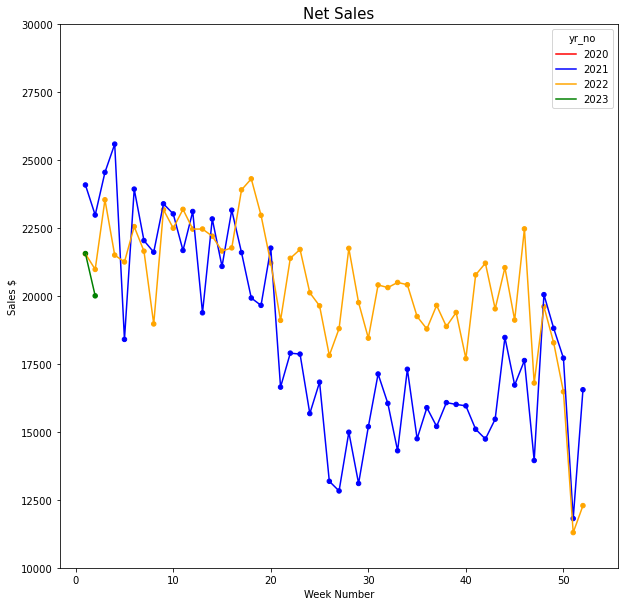

In [84]:
fig,ax = plt.subplots(figsize=(10,10))
ax.set_title('Net Sales', fontsize=15)
ax.set_ylim([10000,30000])

colors = {2020:'red',2021:'blue', 2022:'orange', 2023:'green'}
#ax.scatter(df['population'], df['Area'], c=df['continent'].map(colors))

test5.pivot_table(values="Net_Sales", index="week_no", columns="yr_no").plot.line(ax=ax, color = ['red','blue','orange','green'])
test5.plot.scatter(x="week_no",y="Net_Sales",c=test5["yr_no"].map(colors),ax=ax)

ax.set_ylabel('Sales $')
ax.set_xlabel('Week Number')

fig.savefig("foo.png", bbox_inches='tight', dpi=600)

Include the last date of the measurement period in the analysis

In [19]:
print(concat2.groupby('yr_no')['Time_From_dt'].max())
print(concat2.groupby('yr_no')['Time_From_dt'].min())

yr_no
2021   2021-12-31 03:00:00
2022   2022-12-31 03:00:00
2023   2023-01-15 03:00:00
Name: Time_From_dt, dtype: datetime64[ns]
yr_no
2021   2021-01-01 03:00:00
2022   2022-01-01 03:00:00
2023   2023-01-01 03:00:00
Name: Time_From_dt, dtype: datetime64[ns]


In [4]:
# SINLGLE DF VERSION OF THE ABOVE
#fetch the annual sales report (day interals)
annrep = pd.read_csv('./rawRevelExports/Sales_Summary_greene-hill-food-co-op_2022-01-01_03-00_2022-12-02_03-00.csv')
print(annrep.shape)

(336, 179)


In [5]:
#fix the col headers
annrep.columns = [i.replace(' ','_') for i in annrep.columns]

In [6]:
#keep only those columns whose rows' totals > 0
jk = annrep.select_dtypes('float64').apply('sum')

In [7]:
#rebuild the dataframe
concat = pd.concat([
    annrep.iloc[0:334,:].select_dtypes(exclude = 'float64'),
    annrep.loc[0:334,list(jk[jk.apply(lambda x: x>0)].index)]],axis = 1)

In [8]:
#make new datetime cols (note that these object INCLUDE a time component)
concat = concat.assign(Time_From_dt = pd.to_datetime(concat['Time_From'],format = '%m/%d/%Y %H:%M %p'),Time_To_dt = pd.to_datetime(concat['Time_To'],format = '%m/%d/%Y %H:%M %p'))

In [10]:
#group by week
#calculate sum of values, grouped by week
test = concat.groupby([pd.Grouper(key='Time_From_dt', freq='W')])['Gross_Sales','Net_Sales', 'Total_Discounts'].sum()

/tmp/ipykernel_51777/1441866504.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test = concat.groupby([pd.Grouper(key='Time_From_dt', freq='W')])['Gross_Sales','Net_Sales', 'Total_Discounts'].sum()


In [20]:
#concatenate both the group by calcs and the group by count
test2 = pd.concat([test,concat.groupby([pd.Grouper(key='Time_From_dt', freq='W')])['Gross_Sales'].count()], axis = 1)

In [28]:
#reset the index to place the date as a col
test3 = test2.reset_index()

In [35]:
test3.columns = ['Time_From_dt', 'Gross_Sales', 'Net_Sales', 'Total_Discounts','obs_cnt']

In [37]:
#view the day distribution for ea week group
test3['obs_cnt'].value_counts()

7    47
2     1
3     1
Name: obs_cnt, dtype: int64

## Discounts Analysis

In [54]:
bool_list = [re.search('discount', i.lower()) is not None for i in list(concat2.columns)]
list(compress(list(concat2.columns),bool_list))

['Item_Discounts',
 'Total_Discounts',
 'Donation_Discount_Count',
 'Donation_Discount_Sum']

In [55]:
df = concat2.groupby(['week_no','yr_no'])['Total_Discounts'].sum()
df2 = df.reset_index()
df2.sort_values(by = ['yr_no','week_no'], inplace = True)
df2.reset_index(drop = True,inplace = True)

In [101]:
df2.head()

,week_no,yr_no,Total_Discounts
0,53,2020,345.90
1,1,2021,740.28
2,2,2021,452.56
3,3,2021,811.23
4,4,2021,872.10


In [102]:
test5.head()

,week_no,yr_no,Gross_Sales,Net_Sales,Total_Discounts,obs_cnt,calnder_day,gross_sales_ma
0,1,2021,24824.89,24084.61,740.28,7,2021-01-04,NaN
1,1,2022,22792.65,21552.18,1240.47,7,2022-01-03,17808.465
2,1,2023,22924.12,21561.63,1362.49,7,2023-01-02,16588.545
3,2,2021,23431.33,22978.77,452.56,7,2021-01-11,NaN
4,2,2022,21614.70,20977.93,636.77,7,2022-01-10,18653.820


In [56]:
df2 = df2.assign(rolling_mean = df2.rolling(window = 4).agg({'Total_Discounts':'mean'}))

In [64]:
test5_df2 = test5.merge(df2, how = 'inner',on=['yr_no','week_no'])

In [65]:
test5_df2['yr_no_str'] = test5_df2['yr_no'].astype(str)

In [66]:
test5_df2['yr_wk_str'] = test5_df2['yr_no_str'].str.cat(test5_df2['week_no'].astype(str), sep = '-')

In [67]:
print(df2.shape)
print(test5.shape)
print(test5_df2.shape)

(107, 4)
(107, 8)
(107, 12)


In [68]:
df2.dtypes

week_no             UInt32
yr_no               UInt32
Total_Discounts    float64
rolling_mean       float64
dtype: object

In [75]:
to_chart.tail()

,week_no,yr_no,Gross_Sales,Net_Sales,Total_Discounts_x,obs_cnt,calnder_day,net_sales_ma,Total_Discounts_y,rolling_mean,yr_no_str,yr_wk_str,sales_disc_ratio
101,50,2022,17487.32,16477.88,1009.44,7,2022-12-12,17790.6700,1009.44,859.1250,2022,2022-50,0.048291
103,51,2022,12028.11,11295.78,732.33,7,2022-12-19,16414.9450,732.33,799.1975,2022,2022-51,0.048687
105,52,2022,13914.63,12288.92,1625.71,7,2022-12-26,14585.1900,1625.71,962.1750,2022,2022-52,0.065969
2,1,2023,22924.12,21561.63,1362.49,7,2023-01-02,15406.0525,1362.49,1182.4925,2023,2023-1,0.076755
5,2,2023,20642.90,20005.68,637.22,7,2023-01-09,16288.0025,637.22,1089.4375,2023,2023-2,0.066886


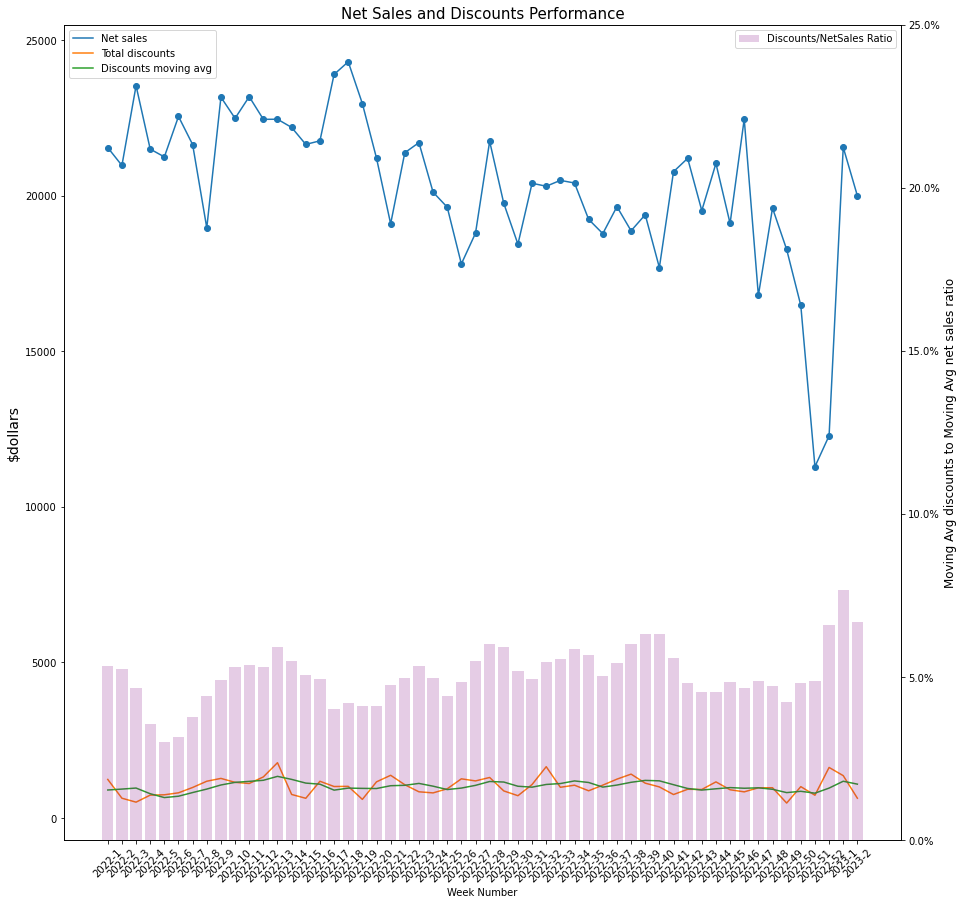

In [86]:
to_chart = test5_df2.loc[test5_df2['yr_no']>2021,].sort_values(['yr_no','week_no'])
#ratio of 4-wk MA of gross sales & Discounts
to_chart['sales_disc_ratio'] = to_chart['rolling_mean']/to_chart['net_sales_ma']

fig,ax1 = plt.subplots(figsize=(15,15))
ax2 = ax1.twinx()

ax1.set_title('Net Sales and Discounts Performance', fontsize=15)
ax1.set_xlabel('Week Number')

#ax.set_ylim([10000,30000])
ax2.set_ylim([0,.25])

colors = {2021:'blue', 2022:'orange', 2023:'green'}
#ax.scatter(df['population'], df['Area'], c=df['continent'].map(colors))

ax1.plot(to_chart['yr_wk_str'], to_chart['Net_Sales'],label = 'Net sales')
#scatter plot to highlight actual data points of the line graphs
ax1.scatter(to_chart['yr_wk_str'], to_chart['Net_Sales'])
#gross discounts
ax1.plot(to_chart['yr_wk_str'], to_chart['Total_Discounts_y'],label = 'Total discounts')
#moving avg of discounts
ax1.plot(to_chart['yr_wk_str'], to_chart['rolling_mean'],label = 'Discounts moving avg')
#ratio of sales-to-discount ratio
ax2.bar(to_chart['yr_wk_str'], to_chart['sales_disc_ratio'],alpha = 0.2, label = 'Discounts/NetSales Ratio', color = 'purple')
ax1.legend(loc = 'upper left')
ax2.legend(loc = 'upper right')
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=45, horizontalalignment='center')

#set label for 2nd axis
ax2.set_ylabel('Moving Avg discounts to Moving Avg net sales ratio', fontsize = 12)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1.0))
ax1.set_ylabel('$dollars', fontsize = 14)

plt.show()

fig.savefig("sales_disc.pdf", bbox_inches='tight', dpi=600)